# One Shot Learning - Siamese Networks

## Imports

In [102]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Funções

In [103]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuração

In [104]:
class Config():
#    training_dir = "./data/faces/training/"
#    testing_dir = "./data/faces/testing/"
    training_dir = "/home/silvio/git/datasets/ds/train/"
    testing_dir = "/home/silvio/git/datasets/ds/test/"
#    training_dir = "/home/silvio/git/datasets/dsNshotcatdog/train/"
#    testing_dir = "/home/silvio/git/datasets/dsNshotcatdog/test/"

    train_batch_size = 16#64 #1 #64
    train_number_epochs = 150 #50 #100

In [105]:
!ls data/faces/training/s11

10.pgm	1.pgm  2.pgm  3.pgm  4.pgm  5.pgm  6.pgm  7.pgm  8.pgm	9.pgm


In [106]:
!ls /home/silvio/git/datasets/ds/training/bruna

ls: cannot access '/home/silvio/git/datasets/ds/training/bruna': No such file or directory


## Classe dataset que controla o acesso aos dados para treino da rede siamesa
* Classe que gera pares de imagens 0 mesmo grupo 1 grupos diferentes

* Init
    * guarda informação da pasta com imagens
    * transformados

* getItem

# O dataset obtem pares de imagens, metade deve estar na mesma classe

In [107]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        #print(self.imageFolderDataset.imgs)
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #print('im0 ' , img0_tuple[0], ' img0_tuple[1] ', img0_tuple[1])
        #50% das imagens devem estar na mesma classe
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
            #print('t1 ' , img1_tuple[0])
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break
            #print('t1 - outra classe ' , img1_tuple[0])
 

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        print('img0_tuple[0] ' , img0_tuple[0], ' img1_tuple[0] ' , img1_tuple[0])
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Dataset de teste

## dataset baseado na pasta com imagens
* utiliza classe ImageFolder que retorna lista dos arquivos com path completo

In [108]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [109]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## visualizando dados

img0_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/muriel/muriel2.jpeg
img0_tuple[0]  /home/silvio/git/datasets/ds/train/muriel/muriel2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/muriel/muriel2.jpeg
img0_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg


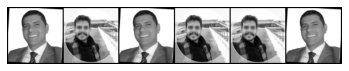

[[1.]
 [0.]
 [0.]]


In [113]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition

In [87]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss
* Calcula a distancia euclidiana entre duas distribuições e compara com o label considerando uma margem
* esse loss penaliza a predição que retornar uma valor alto para dois outputs com valores muito similares
* O que se espera ao final é que ao passar dois output similares o valor da distancia euclidiana seja baixo

In [88]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## treino

In [89]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [90]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [91]:
counter = []
loss_history = [] 
iteration_number= 0

img0_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg
torch.Size([1, 100, 100])
img0_tuple[0]  /home/silvio/git/datasets/ds/train/muriel/muriel2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg
torch.Size([1, 100, 100])
img0_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/daniel/daniel2.jpeg
torch.Size([1, 100, 100])
Epoch number 0
 Current loss 2.2216033935546875

img0_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/daniel/daniel2.jpeg
torch.Size([1, 100, 100])
img0_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg
torch.Size([1, 100, 100])
img0_tuple[0]  /home/silvio/git/datasets/ds/train/muriel/muriel2.jpeg  img

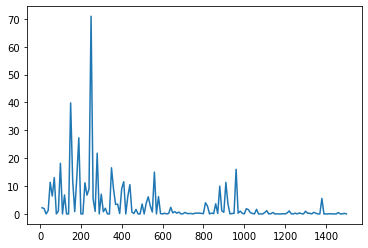

In [92]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch  {}\n  loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

# comparando distancia euclidiana da base de treino

In [94]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
print(type(example_batch))
print(example_batch[2].numpy())
print('1 grupo diferente 0 mesmo grupo')
print('Distancia euclidiana alta para fotos de grupos diferentes')

img0, img1 , label = example_batch
img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()

output1,output2 = net(img0,img1)
euclidean_distance = F.pairwise_distance(output1, output2)
print(euclidean_distance)

img0_tuple[0]  /home/silvio/git/datasets/ds/train/daniel/daniel2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/muriel/muriel2.jpeg
torch.Size([1, 100, 100])
img0_tuple[0]  /home/silvio/git/datasets/ds/train/daniel/daniel2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/cristiano/cristiano2.jpeg
torch.Size([1, 100, 100])
img0_tuple[0]  /home/silvio/git/datasets/ds/train/daniel/daniel2.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/train/daniel/daniel2.jpeg
torch.Size([1, 100, 100])
<class 'list'>
[[1.]
 [1.]
 [0.]]
1 grupo diferente 0 mesmo grupo
Distancia euclidiana alta para fotos de grupos diferentes
tensor([26.3174, 11.4751,  2.3414], device='cuda:0', grad_fn=<NormBackward1>)


# comparando distancia euclidiana da base de teste
* 1 grupo diferente 0 mesmo grupo
* Distancia euclidiana alta para fotos de grupos diferentes

In [97]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=116)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
print(type(example_batch[0]),type(example_batch[1]))

print(example_batch[2].numpy())
print('1 grupo diferente 0 mesmo grupo')
print('Distancia euclidiana alta para fotos de grupos diferentes')

img0, img1 , label = example_batch
img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()

output1,output2 = net(img0,img1)
euclidean_distance = F.pairwise_distance(output1, output2)
print(euclidean_distance)

img0_tuple[0]  /home/silvio/git/datasets/ds/test/cristiano/cristiano1.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/test/bruna/bruna1.jpeg
torch.Size([1, 100, 100])
img0_tuple[0]  /home/silvio/git/datasets/ds/test/daniel/daniel1.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/test/daniel/daniel1.jpeg
torch.Size([1, 100, 100])
img0_tuple[0]  /home/silvio/git/datasets/ds/test/bruna/bruna1.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/test/bruna/bruna1.jpeg
torch.Size([1, 100, 100])
img0_tuple[0]  /home/silvio/git/datasets/ds/test/bruna/bruna1.jpeg  img1_tuple[0]  /home/silvio/git/datasets/ds/test/muriel/Muriel1.jpeg
torch.Size([1, 100, 100])
<class 'torch.Tensor'> <class 'torch.Tensor'>
sh  torch.Size([4, 1, 100, 100])
sh 2 torch.Size([4, 1, 100, 100])
[[1.]
 [0.]
 [0.]
 [1.]]
1 grupo diferente 0 mesmo grupo
Distancia euclidiana alta para fotos de grupos diferentes
tensor([1.2263, 0.3660, 0.2034, 1.6852], device='cuda:0',
       grad_fn=<NormBackward1>)


# Loop para predição
* Calcula distancia euclidina da imagem passada com todas as imagens da base

In [101]:
transform=transforms.Compose([transforms.Resize((100,100)), 
                                transforms.ToTensor() ])

for x in range(len(folder_dataset_test)):
    img_tuple1 = folder_dataset_test[x]

    for y in range(len(folder_dataset_test)):
        img_tuple2 = folder_dataset_test[y]
        
        img0 = img_tuple1[0]

        img10 = img0.convert("L")

        
        img1 = img_tuple2[0]
        img11 = img1.convert("L")       
        x0 = transform(img10)
        x1 = transform(img11)
        
        x0=x0.reshape(1,1,100,100)    
        x1=x1.reshape(1,1,100,100)  
        
        x0, x1 = x0.cuda(), x1.cuda() 
        output1,output2 = net(x0,x1)

        euclidean_distance = F.pairwise_distance(output1, output2)
        
        print(x,y,format(euclidean_distance.item(), '.6f'))
        

0 0 0.000002
0 1 0.804223
0 2 1.235395
0 3 1.570104
1 0 0.804219
1 1 0.000002
1 2 0.496757
1 3 0.950577
2 0 1.235392
2 1 0.496754
2 2 0.000002
2 3 1.069518
3 0 1.570101
3 1 0.950574
3 2 1.069517
3 3 0.000002
